In [1]:
import tensorflow as tf

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
import os

In [4]:
import matplotlib.pyplot as plt

In [5]:
import pydot

In [6]:
!dir

 Volume in drive C is Windows-SSD
 Volume Serial Number is F0FA-3D4D

 Directory of C:\Users\amand\OneDrive\Data Science\ANA500\WEEK 1

10/23/2022  07:07 PM    <DIR>          .
10/23/2022  06:57 PM    <DIR>          ..
10/23/2022  07:07 PM    <DIR>          .ipynb_checkpoints
05/09/2022  12:58 PM            24,876 CDLA-Permissive-2.0.pdf
10/23/2022  06:09 PM         1,154,898 Final.ipynb
10/09/2022  04:06 PM            32,972 HW1.ipynb
10/16/2022  08:26 PM           116,655 HW3.ipynb
10/22/2022  11:00 AM    <DIR>          kagglecatsanddogs_3367a
10/02/2022  08:00 PM           174,442 MicroProject #1.pptx
10/16/2022  09:51 PM             8,774 Midterm.ipynb
02/10/2017  10:51 AM               104 readme[1].txt
10/23/2022  02:24 PM        33,623,896 save_at_1.h5
10/23/2022  03:03 PM        33,623,896 save_at_2.h5
10/23/2022  03:43 PM        33,623,896 save_at_3.h5
10/23/2022  04:22 PM        33,623,896 save_at_4.h5
10/23/2022  05:02 PM        33,623,896 save_at_5.h5
10/23/2022  07:04 PM  

In [7]:
!dir Superman-VS-Batman 

 Volume in drive C is Windows-SSD
 Volume Serial Number is F0FA-3D4D

 Directory of C:\Users\amand\OneDrive\Data Science\ANA500\WEEK 1\Superman-VS-Batman

10/23/2022  07:04 PM    <DIR>          .
10/23/2022  07:09 PM    <DIR>          ..
10/23/2022  07:04 PM    <DIR>          Batman
10/23/2022  07:04 PM    <DIR>          Superman
               0 File(s)              0 bytes
               4 Dir(s)  106,124,242,944 bytes free


In [9]:
!dir Superman-VS-Batman\Superhero

 Volume in drive C is Windows-SSD
 Volume Serial Number is F0FA-3D4D

 Directory of C:\Users\amand\OneDrive\Data Science\ANA500\WEEK 1\Superman-VS-Batman\Superhero

10/23/2022  07:10 PM    <DIR>          .
10/23/2022  07:10 PM    <DIR>          ..
10/23/2022  07:04 PM    <DIR>          Batman
10/23/2022  07:04 PM    <DIR>          Superman
               0 File(s)              0 bytes
               4 Dir(s)  106,095,890,432 bytes free


In [10]:
data_file= 'Superman-VS-Batman\Superhero'
data_file

'Superman-VS-Batman\\Superhero'

In [12]:
num_skipped = 0
for folder_name in ("Batman", "Superman"):
    folder_path = os.path.join(data_file, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()
        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1 images


In [13]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_file,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_file,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 18 files belonging to 2 classes.
Using 15 files for training.
Found 18 files belonging to 2 classes.
Using 3 files for validation.


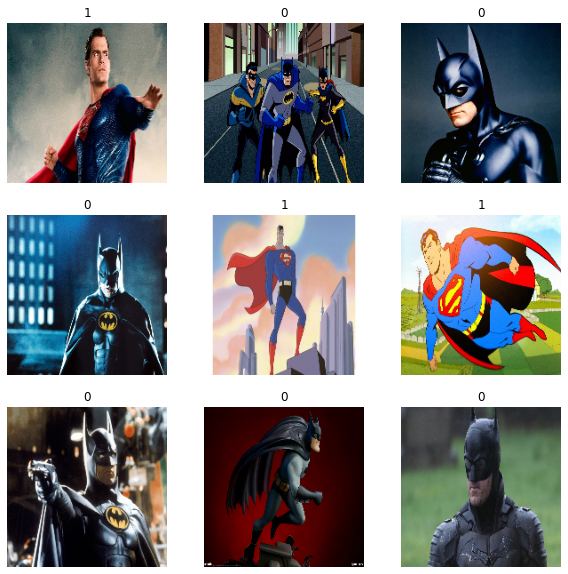

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [15]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

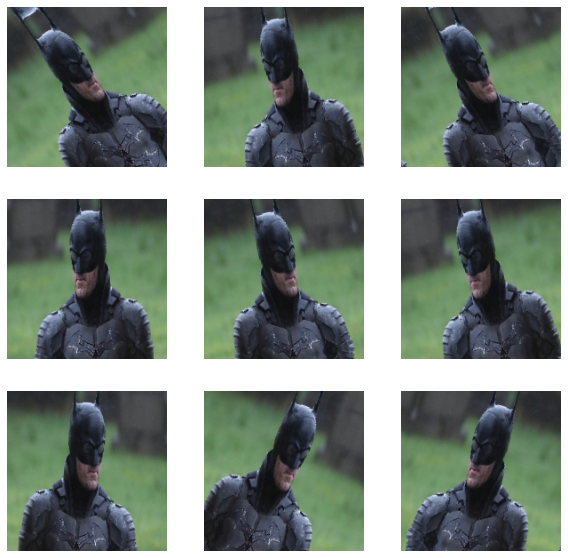

In [16]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [17]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [18]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [19]:
epochs = 5

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/5
1/1 [==============================] - 15s 15s/step - loss: 0.7468 - accuracy: 0.5333 - val_loss: 0.6918 - val_accuracy: 0.6667
Epoch 2/5
1/1 [==============================] - 4s 4s/step - loss: 0.3084 - accuracy: 0.9333 - val_loss: 0.6915 - val_accuracy: 0.6667
Epoch 3/5
1/1 [==============================] - 3s 3s/step - loss: 0.1840 - accuracy: 0.8000 - val_loss: 0.6917 - val_accuracy: 0.6667
Epoch 4/5
1/1 [==============================] - 3s 3s/step - loss: 0.0961 - accuracy: 1.0000 - val_loss: 0.6922 - val_accuracy: 0.6667
Epoch 5/5
1/1 [==============================] - 3s 3s/step - loss: 0.0925 - accuracy: 1.0000 - val_loss: 0.6929 - val_accuracy: 0.3333


In [23]:
img = keras.preprocessing.image.load_img(
 data_set, target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

NameError: name 'Superman' is not defined